# Propagate Yourself : Insights

### Tactical imports

In [1]:
import torch
import torch.nn.functional as F
from torch import nn

from math import *
import random

import cv2
from einops import rearrange

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

from medianpool import MedianPool2d



### Cutout functions

In [2]:
def default(val, def_val):
    return def_val if val is None else val

def cutout_coordinates(image, ratio_range = (0.6, 0.8)):
    _,_,orig_h, orig_w = image.shape

    ratio_lo, ratio_hi = ratio_range
    random_ratio = ratio_lo + random.random() * (ratio_hi - ratio_lo)
    w, h = floor(random_ratio * orig_w), floor(random_ratio * orig_h)
    coor_x = floor((orig_w - w) * random.random())
    coor_y = floor((orig_h - h) * random.random())
    return ((coor_y, coor_y + h), (coor_x, coor_x + w)), random_ratio

def cutout_and_resize(image, coordinates, output_size = None, mode = 'nearest', stride = 16):
    shape = image.shape
    output_size = default(output_size, shape[2:])
    (y0, y1), (x0, x1) = coordinates
    cutout_image = image[:,:,y0:y1, x0:x1]
    if mode=='avgpool':
        return F.avg_pool2d(cutout_image, kernel_size=((cutout_image.shape[2]-output_size[0]*stride)+stride, (cutout_image.shape[3]-output_size[1]*stride)+stride),stride=stride)
    elif mode=='maxpool':
        return F.max_pool2d(cutout_image, kernel_size=((cutout_image.shape[2]-output_size[0]*stride)+stride, (cutout_image.shape[3]-output_size[1]*stride)+stride),stride=stride)
    elif mode=='medianpool':
        medpool = MedianPool2d(kernel_size=((cutout_image.shape[2]-output_size[0]*stride)+stride, (cutout_image.shape[3]-output_size[1]*stride)+stride),stride=stride)
        return medpool(cutout_image)
    else:
        return F.interpolate(cutout_image, size = output_size, mode = mode)


In [3]:
def get_xy_width_heights(coords):
    return (min(coords[1][0], coords[1][1]),min(coords[0][0], coords[0][1])), abs(coords[1][0]- coords[1][1]),abs(coords[0][0]- coords[0][1])

### Import Images and get crops

In [4]:
num_image = '1061'

(-0.5, 499.5, 374.5, -0.5)

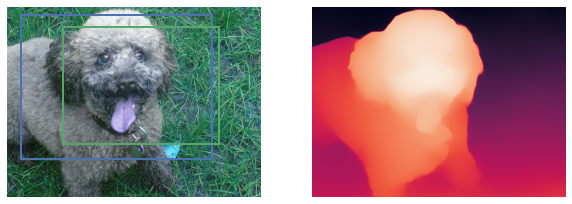

In [5]:

from matplotlib.patches import Rectangle

img = torch.from_numpy(cv2.imread('images/n02113712/n02113712_'+num_image+'.JPEG')).permute(2,0,1).unsqueeze(0)
depth = torch.from_numpy(cv2.imread('depthmaps/n02113712/n02113712_'+num_image+'.png',cv2.IMREAD_GRAYSCALE)).unsqueeze(0).unsqueeze(0).float()      


distance_thres = 0.7
distance_thres_wdepth = 0.7



cutout_interpolate_mode = 'nearest'
coord_cutout_interpolate_mode = 'bilinear'
cutout_ratio_range = (0.3, 0.8)
features_shape = (8,8)

shape = img.shape


cutout_coordinates_one, _ = cutout_coordinates(img, cutout_ratio_range)
cutout_coordinates_two, _ = cutout_coordinates(img, cutout_ratio_range)


plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img.permute(0,2,3,1).squeeze())
plt.gca().add_patch(Rectangle(*get_xy_width_heights(cutout_coordinates_one),linewidth=2,edgecolor='b',facecolor='none'))
plt.gca().add_patch(Rectangle(*get_xy_width_heights(cutout_coordinates_two),linewidth=2,edgecolor='g',facecolor='none'))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(depth.permute(0,2,3,1).squeeze())
plt.axis('off')




/home/bensaad/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/bensaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


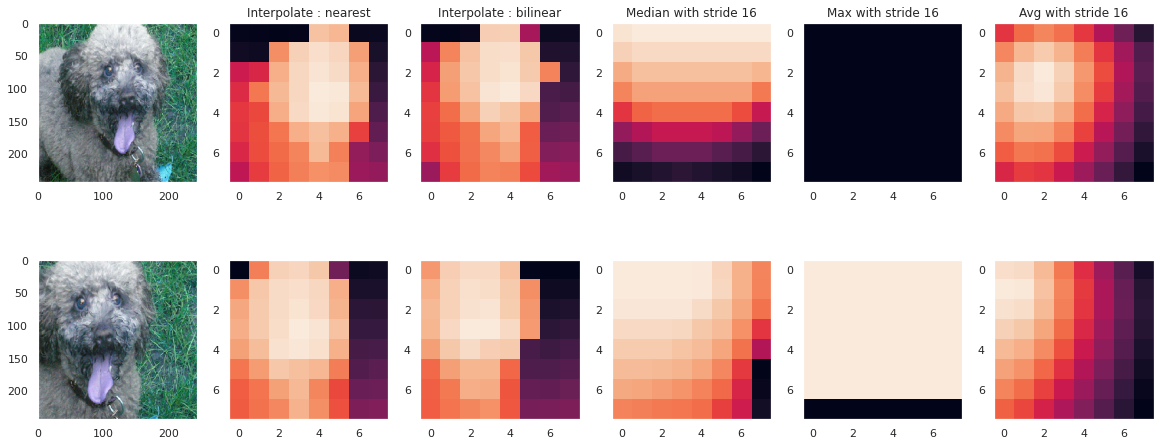

In [6]:

image_one_cutout = cutout_and_resize(img, cutout_coordinates_one, output_size = (244,244), mode = cutout_interpolate_mode)
image_two_cutout = cutout_and_resize(img, cutout_coordinates_two, output_size = (244,244), mode = cutout_interpolate_mode)
image_h, image_w = shape[2:]

proj_image_shape = features_shape
proj_image_h, proj_image_w = proj_image_shape

coordinates = torch.meshgrid(
    torch.arange(image_h).type_as(img),
    torch.arange(image_w).type_as(img)
)


stride = 16

depth_one_cutout_bil = cutout_and_resize(depth, cutout_coordinates_one, output_size = proj_image_shape, mode = coord_cutout_interpolate_mode)
depth_two_cutout_bil = cutout_and_resize(depth, cutout_coordinates_two, output_size = proj_image_shape, mode = coord_cutout_interpolate_mode)


depth_one_cutout_median = cutout_and_resize(depth, cutout_coordinates_one, output_size = proj_image_shape, mode = 'medianpool', stride = stride) 
depth_two_cutout_median = cutout_and_resize(depth, cutout_coordinates_two, output_size = proj_image_shape, mode = 'medianpool', stride = stride) 

depth_one_cutout_max = cutout_and_resize(depth, cutout_coordinates_one, output_size = proj_image_shape, mode = 'maxpool', stride = stride) 
depth_two_cutout_max = cutout_and_resize(depth, cutout_coordinates_two, output_size = proj_image_shape, mode = 'maxpool', stride = stride) 


depth_one_cutout_avg = cutout_and_resize(depth, cutout_coordinates_one, output_size = proj_image_shape, mode = 'avgpool', stride = stride) 
depth_two_cutout_avg = cutout_and_resize(depth, cutout_coordinates_two, output_size = proj_image_shape, mode = 'avgpool', stride = stride) 


depth_one_cutout = cutout_and_resize(depth, cutout_coordinates_one, output_size = proj_image_shape, mode = cutout_interpolate_mode) 
depth_two_cutout = cutout_and_resize(depth, cutout_coordinates_two, output_size = proj_image_shape, mode = cutout_interpolate_mode) 


plt.figure(figsize=(20,8))
plt.rcParams["axes.grid"] = False

plt.subplot(2,6,1)
plt.imshow(image_one_cutout.permute(0,2,3,1).squeeze())

plt.subplot(2,6,2)
plt.title("Interpolate : nearest")
plt.imshow(depth_one_cutout.permute(0,2,3,1).squeeze())

plt.subplot(2,6,3)
plt.title("Interpolate : bilinear")
plt.imshow(depth_one_cutout_bil.permute(0,2,3,1).squeeze())

plt.subplot(2,6,4)
plt.title(f"Median with stride {stride}")
plt.imshow(depth_one_cutout_median.permute(0,2,3,1).squeeze())

plt.subplot(2,6,5)
plt.title(f"Max with stride {stride}")
plt.imshow(depth_one_cutout_max.permute(0,2,3,1).squeeze())

plt.subplot(2,6,6)
plt.title(f"Avg with stride {stride}")
plt.imshow(depth_one_cutout_avg.permute(0,2,3,1).squeeze())


plt.subplot(2,6,7)
plt.imshow(image_two_cutout.permute(0,2,3,1).squeeze())

plt.subplot(2,6,8)
plt.imshow(depth_two_cutout.permute(0,2,3,1).squeeze())

plt.subplot(2,6,9)
plt.imshow(depth_two_cutout_bil.permute(0,2,3,1).squeeze())

plt.subplot(2,6,10)
plt.imshow(depth_two_cutout_median.permute(0,2,3,1).squeeze())

plt.subplot(2,6,11)
plt.imshow(depth_two_cutout_max.permute(0,2,3,1).squeeze())

plt.subplot(2,6,12)
plt.imshow(depth_two_cutout_avg.permute(0,2,3,1).squeeze())



In [ ]:
depth_one_cutout

### The normal way : extract coordinates and calculate distance

In [7]:

coordinates_tensor = torch.stack(coordinates).unsqueeze(0).float()
coordinates_tensor /= sqrt(image_h ** 2 + image_w ** 2)
coordinates_tensor[:, 0] *= proj_image_h
coordinates_tensor[:, 1] *= proj_image_w





proj_coors_one = cutout_and_resize(coordinates_tensor, cutout_coordinates_one, output_size = proj_image_shape, mode = coord_cutout_interpolate_mode) 
proj_coors_two = cutout_and_resize(coordinates_tensor, cutout_coordinates_two, output_size = proj_image_shape, mode = coord_cutout_interpolate_mode) 

proj_coors_one, proj_coors_two = map(lambda t: rearrange(t, 'b c h w -> (b h w) c'), (proj_coors_one, proj_coors_two))
proj_depth_one_cutout, proj_depth_two_cutout = map(lambda t: rearrange(t, 'b c h w -> (b h w ) c'), (depth_one_cutout, depth_two_cutout))
pdist = nn.PairwiseDistance(p = 2)

num_pixels = proj_coors_one.shape[0]


proj_coors_one_expanded = proj_coors_one[:, None].expand(num_pixels, num_pixels, -1).reshape(num_pixels * num_pixels, 2)
proj_coors_two_expanded = proj_coors_two[None, :].expand(num_pixels, num_pixels, -1).reshape(num_pixels * num_pixels, 2)

proj_depth_one_expanded = proj_depth_one_cutout[:, None].expand(num_pixels, num_pixels, -1).reshape(num_pixels * num_pixels, 1)
proj_depth_two_expanded = proj_depth_two_cutout[None, :].expand(num_pixels, num_pixels, -1).reshape(num_pixels * num_pixels, 1)



distance_matrix = pdist(proj_coors_one_expanded, proj_coors_two_expanded) 
distance_matrix = distance_matrix.reshape(num_pixels, num_pixels)


intensity_matrix = pdist(proj_depth_one_expanded/255, proj_depth_two_expanded/255).reshape(num_pixels, num_pixels)


positive_mask_one_two = distance_matrix < distance_thres
positive_mask_two_one = positive_mask_one_two.t()



### Adding the depth to distance independantly

In [8]:

distance_matrix_wdepth_added = pdist(proj_coors_one_expanded, proj_coors_two_expanded)
distance_matrix_wdepth_added = distance_matrix_wdepth_added.reshape(num_pixels, num_pixels)

positive_mask_one_two_wdepth_added = distance_matrix_wdepth_added < distance_thres
positive_mask_one_two_wdepth_added = positive_mask_one_two_wdepth_added * (intensity_matrix < 0.2)
positive_mask_two_one_wdepth_added = positive_mask_one_two_wdepth_added.t()


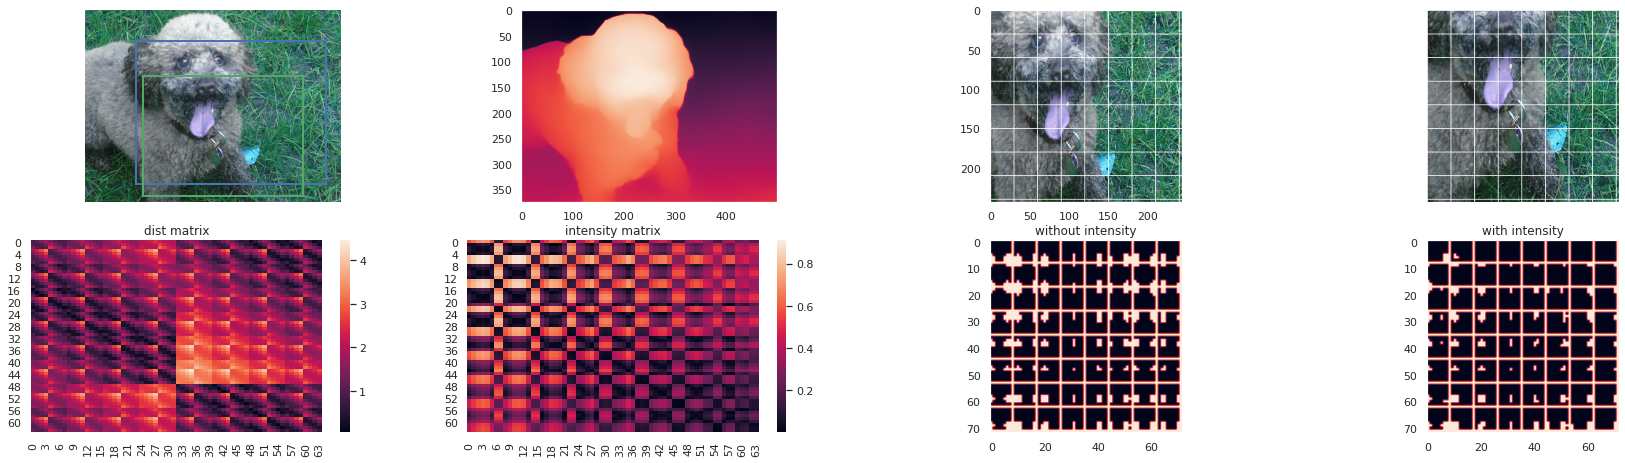

In [9]:

plt.figure(figsize=(30,12))

plt.subplot(3,4,1)
plt.imshow(img.permute(0,2,3,1).squeeze())
plt.gca().add_patch(Rectangle(*get_xy_width_heights(cutout_coordinates_one),linewidth=2,edgecolor='b',facecolor='none'))
plt.gca().add_patch(Rectangle(*get_xy_width_heights(cutout_coordinates_two),linewidth=2,edgecolor='g',facecolor='none'))
plt.axis('off')

plt.subplot(3,4,2)
plt.imshow(depth.permute(0,2,3,1).squeeze())
plt.subplot(3,4,3)
dx, dy = 244//8,244//8
pimg_one = image_one_cutout.permute(0,2,3,1).squeeze().numpy()
# Custom (rgb) grid color
grid_color = [255,255,255]

# Modify the image to include the grid
pimg_one[:,::dy,:] = grid_color
pimg_one[::dx,:,:] = grid_color

plt.imshow(pimg_one)

plt.subplot(3,4,4)
pimg_two = image_two_cutout.permute(0,2,3,1).squeeze().numpy()
# Custom (rgb) grid color
grid_color = [255,255,255]

# Modify the image to include the grid
pimg_two[:,::dy,:] = grid_color
pimg_two[::dx,:,:] = grid_color

plt.imshow(pimg_two)




plt.axis('off')
plt.subplot(3,4,5)
plt.title('dist matrix')
sns.heatmap(distance_matrix_wdepth_added)
plt.subplot(3,4,6)
plt.title('intensity matrix')
sns.heatmap(intensity_matrix)
plt.subplot(3,4,7)
plt.title('without intensity')
imgg = torch.ones((72,72))

for i in range(8):
    for j in range(8):
        lien = positive_mask_one_two[8*i+j,:]
        imgg[9*i:9*(i+1)-1,9*j:9*(j+1)-1] = lien.view(8,8)
        plt.imshow(imgg)
plt.subplot(3,4,8)
plt.title('with intensity')
imgg = torch.ones((72,72))

for i in range(8):
    for j in range(8):
        lien = positive_mask_one_two_wdepth_added[8*i+j,:]
        imgg[9*i:9*(i+1)-1,9*j:9*(j+1)-1] = lien.view(8,8)
        plt.imshow(imgg)



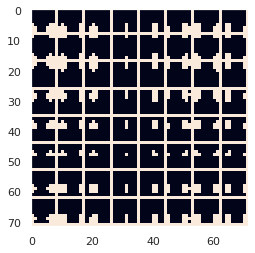

In [10]:
img = torch.ones((72,72))

for i in range(8):
    for j in range(8):
        lien = positive_mask_one_two[8*i+j,:]
        img[9*i:9*(i+1)-1,9*j:9*(j+1)-1] = lien.view(8,8)
        plt.imshow(img)

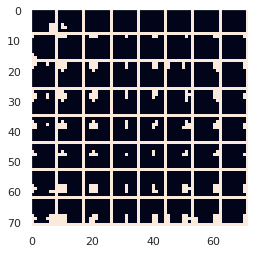

In [11]:
img = torch.ones((72,72))

for i in range(8):
    for j in range(8):
        lien = positive_mask_one_two_wdepth_added[8*i+j,:]
        img[9*i:9*(i+1)-1,9*j:9*(j+1)-1] = lien.view(8,8)
        plt.imshow(img)

In [12]:
print(f'{(positive_mask_one_two_wdepth_added != positive_mask_one_two).sum()} / {positive_mask_one_two.sum()}')

235 / 509


In [13]:
positive_mask_one_two[8,7]

tensor(True)

In [14]:
for i in range(64):
    for j in range(64):
        if positive_mask_one_two_wdepth_added[i,j]==False and positive_mask_one_two[i,j]==True:
            print(i,j)

0 40
0 48
0 49
0 53
0 56
0 57
0 61
1 47
1 48
1 55
1 56
1 57
1 58
1 63
2 42
2 49
2 50
2 51
2 57
2 58
2 59
3 44
3 52
3 60
4 44
4 45
4 52
4 53
4 60
4 61
5 45
5 46
5 48
5 53
5 54
5 55
5 56
5 61
5 62
5 63
6 40
6 41
6 47
6 48
6 49
6 54
6 55
6 56
6 57
6 62
6 63
7 41
7 42
7 49
7 50
7 55
7 57
7 58
7 63
8 6
8 7
8 54
8 61
8 62
8 63
9 7
9 49
9 55
9 56
9 57
9 58
9 63
10 50
10 57
10 58
10 59
11 60
12 52
12 53
12 60
12 61
13 0
13 5
13 54
13 56
13 61
13 62
14 0
14 1
14 48
14 55
14 56
14 57
14 62
14 63
15 1
15 2
15 49
15 50
15 57
15 58
15 63
16 6
16 7
16 14
16 15
17 7
17 15
21 6
21 7
21 14
22 0
22 1
22 8
22 9
23 1
23 2
23 9
23 10
24 6
24 7
24 14
24 15
24 22
24 23
24 30
25 7
25 15
25 23
25 31
28 21
28 28
28 29
29 0
29 5
29 8
29 13
29 16
29 21
30 0
30 1
30 8
30 9
30 16
30 17
30 24
31 1
31 2
31 9
31 10
31 17
31 18
31 25
31 26
32 14
32 15
32 22
32 23
32 29
32 30
32 31
33 15
33 23
33 31
36 12
36 29
37 13
37 16
37 21
37 24
38 8
38 9
38 16
38 17
38 24
38 25
39 9
39 10
39 17
39 18
39 25
39 26
40 22
40 29
40 30

### Adding the depth as 3rd dimension for distance calculation

In [18]:

coordinates_tensor = torch.stack([*coordinates,depth.squeeze()]).unsqueeze(0).float()
coordinates_tensor /= sqrt(image_h ** 2 + image_w ** 2 + int(floor(torch.max(depth))) ** 2)
coordinates_tensor[:, 0] *= proj_image_h
coordinates_tensor[:, 1] *= proj_image_w
coordinates_tensor[:, 2] *= int(floor(torch.max(depth)))




proj_coors_one = cutout_and_resize(coordinates_tensor, cutout_coordinates_one, output_size = proj_image_shape, mode = coord_cutout_interpolate_mode) 
proj_coors_two = cutout_and_resize(coordinates_tensor, cutout_coordinates_two, output_size = proj_image_shape, mode = coord_cutout_interpolate_mode) 

proj_coors_one, proj_coors_two = map(lambda t: rearrange(t, 'b c h w -> (b h w) c'), (proj_coors_one, proj_coors_two))
pdist = nn.PairwiseDistance(p = 2)

num_pixels = proj_coors_one.shape[0]


proj_coors_one_expanded = proj_coors_one[:, None].expand(num_pixels, num_pixels, -1).reshape(num_pixels * num_pixels, 3)
proj_coors_two_expanded = proj_coors_two[None, :].expand(num_pixels, num_pixels, -1).reshape(num_pixels * num_pixels, 3)


distance_matrix_wdepth_catted = pdist(proj_coors_one_expanded, proj_coors_two_expanded) 
distance_matrix_wdepth_catted = distance_matrix_wdepth_catted.reshape(num_pixels, num_pixels)

positive_mask_one_two_wdepth_catted = distance_matrix_wdepth_catted < distance_thres_wdepth
positive_mask_two_one = positive_mask_one_two.t()

In [19]:
(positive_mask_one_two_wdepth_catted != positive_mask_one_two).sum()

tensor(566)

RuntimeError: number of dims don't match in permute

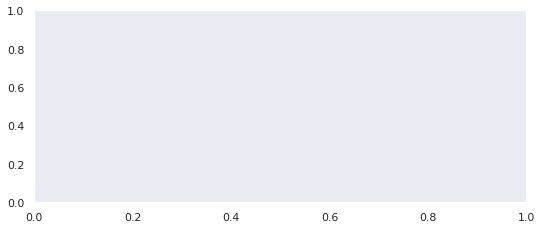

In [20]:
plt.figure(figsize=(30,12))

plt.subplot(3,3,1)
plt.imshow(img.permute(0,2,3,1).squeeze())
plt.gca().add_patch(Rectangle(*get_xy_width_heights(cutout_coordinates_one),linewidth=2,edgecolor='b',facecolor='none'))
plt.gca().add_patch(Rectangle(*get_xy_width_heights(cutout_coordinates_two),linewidth=2,edgecolor='g',facecolor='none'))
plt.axis('off')

plt.subplot(3,3,2)
plt.imshow(depth.permute(0,2,3,1).squeeze())


plt.axis('off')
plt.subplot(3,3,4)
sns.heatmap(positive_mask_one_two)
plt.subplot(3,3,5)
plt.title('with depth added')
sns.heatmap(positive_mask_one_two_wdepth_added)
plt.subplot(3,3,6)
plt.title('with depth catted')
sns.heatmap(positive_mask_one_two_wdepth_catted)
plt.subplot(3,3,7)
sns.heatmap(distance_matrix)
plt.subplot(3,3,8)
sns.heatmap(intensity_matrix)
plt.subplot(3,3,9)
sns.heatmap(distance_matrix_wdepth_catted)
plt.tight_layout()



<AxesSubplot:>

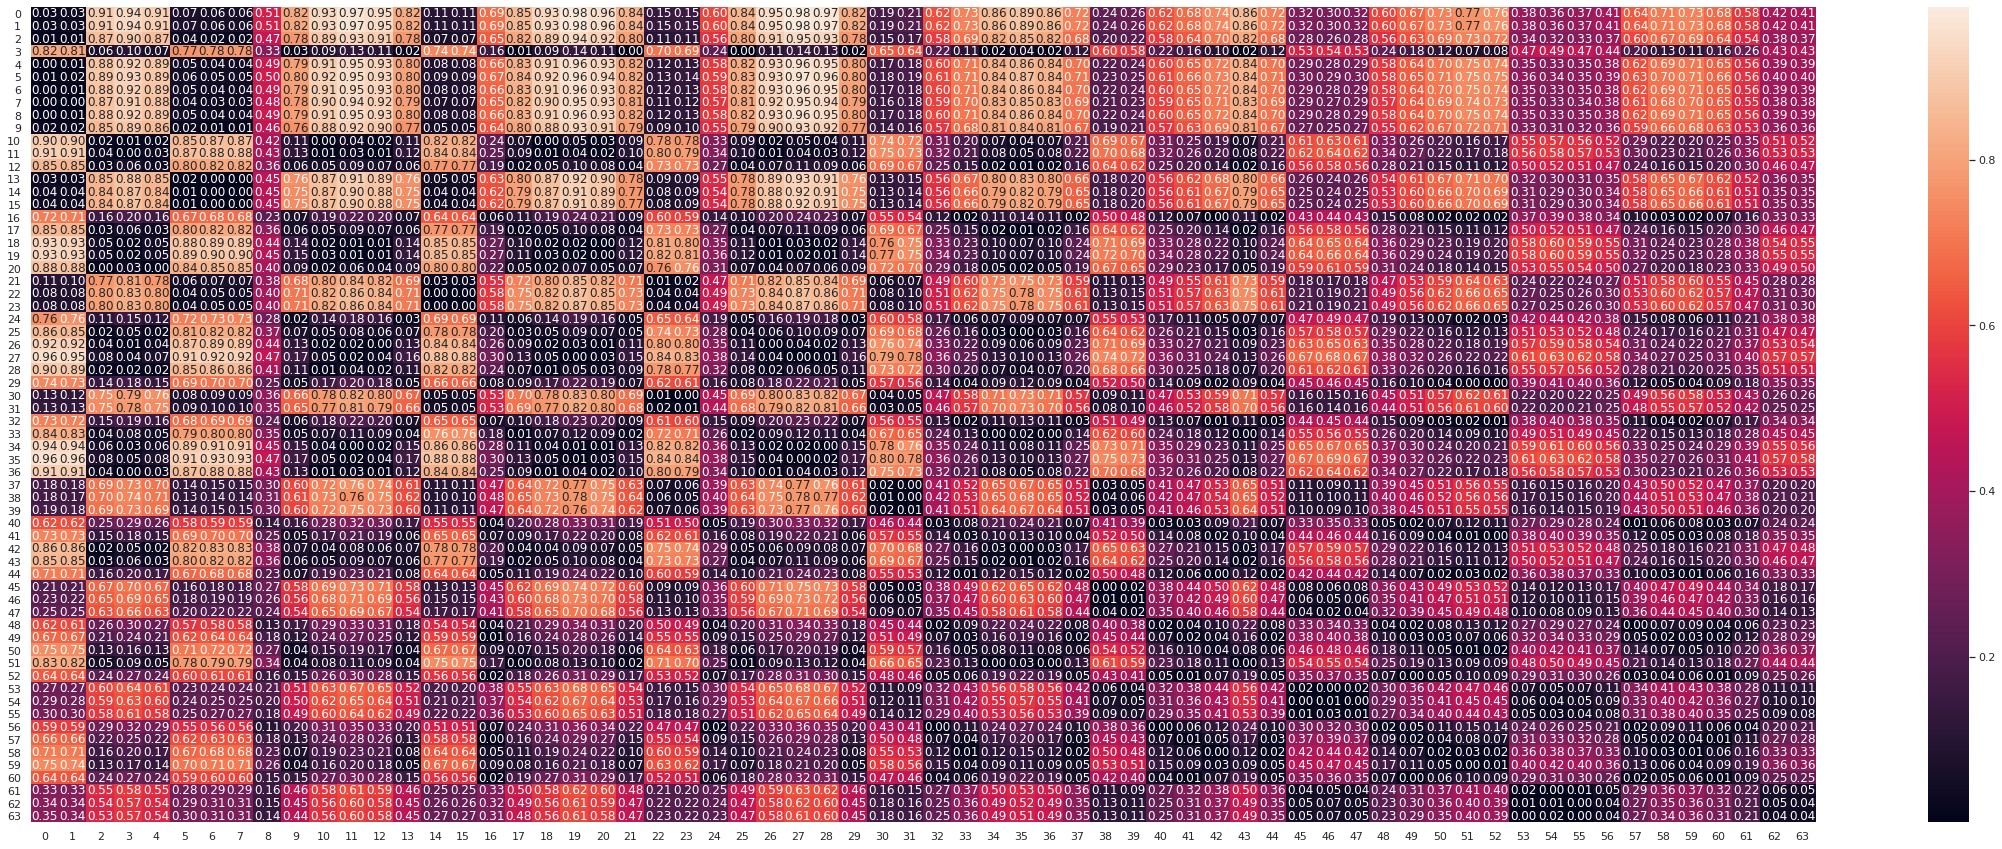

In [21]:
plt.figure(figsize=(40,15))
sns.heatmap(intensity_matrix, annot=True,fmt='0.2f')


<AxesSubplot:>

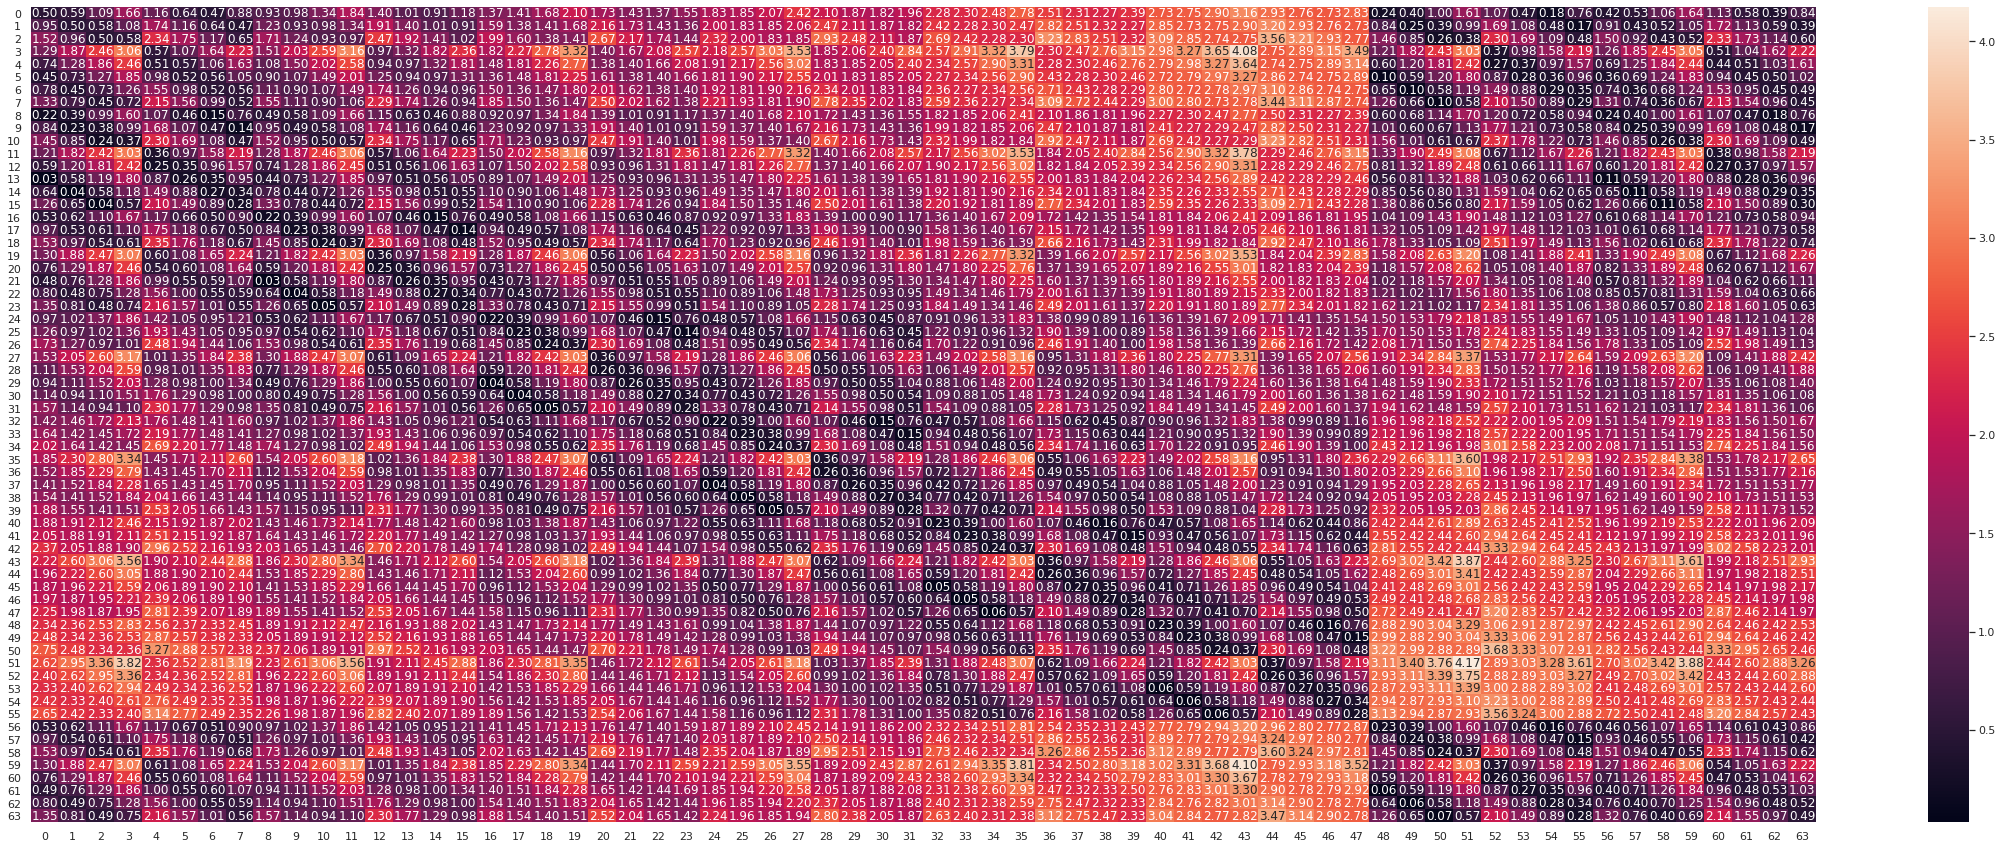

In [22]:
plt.figure(figsize=(40,15))
sns.heatmap(distance_matrix, annot=True,fmt='0.2f')


<AxesSubplot:>

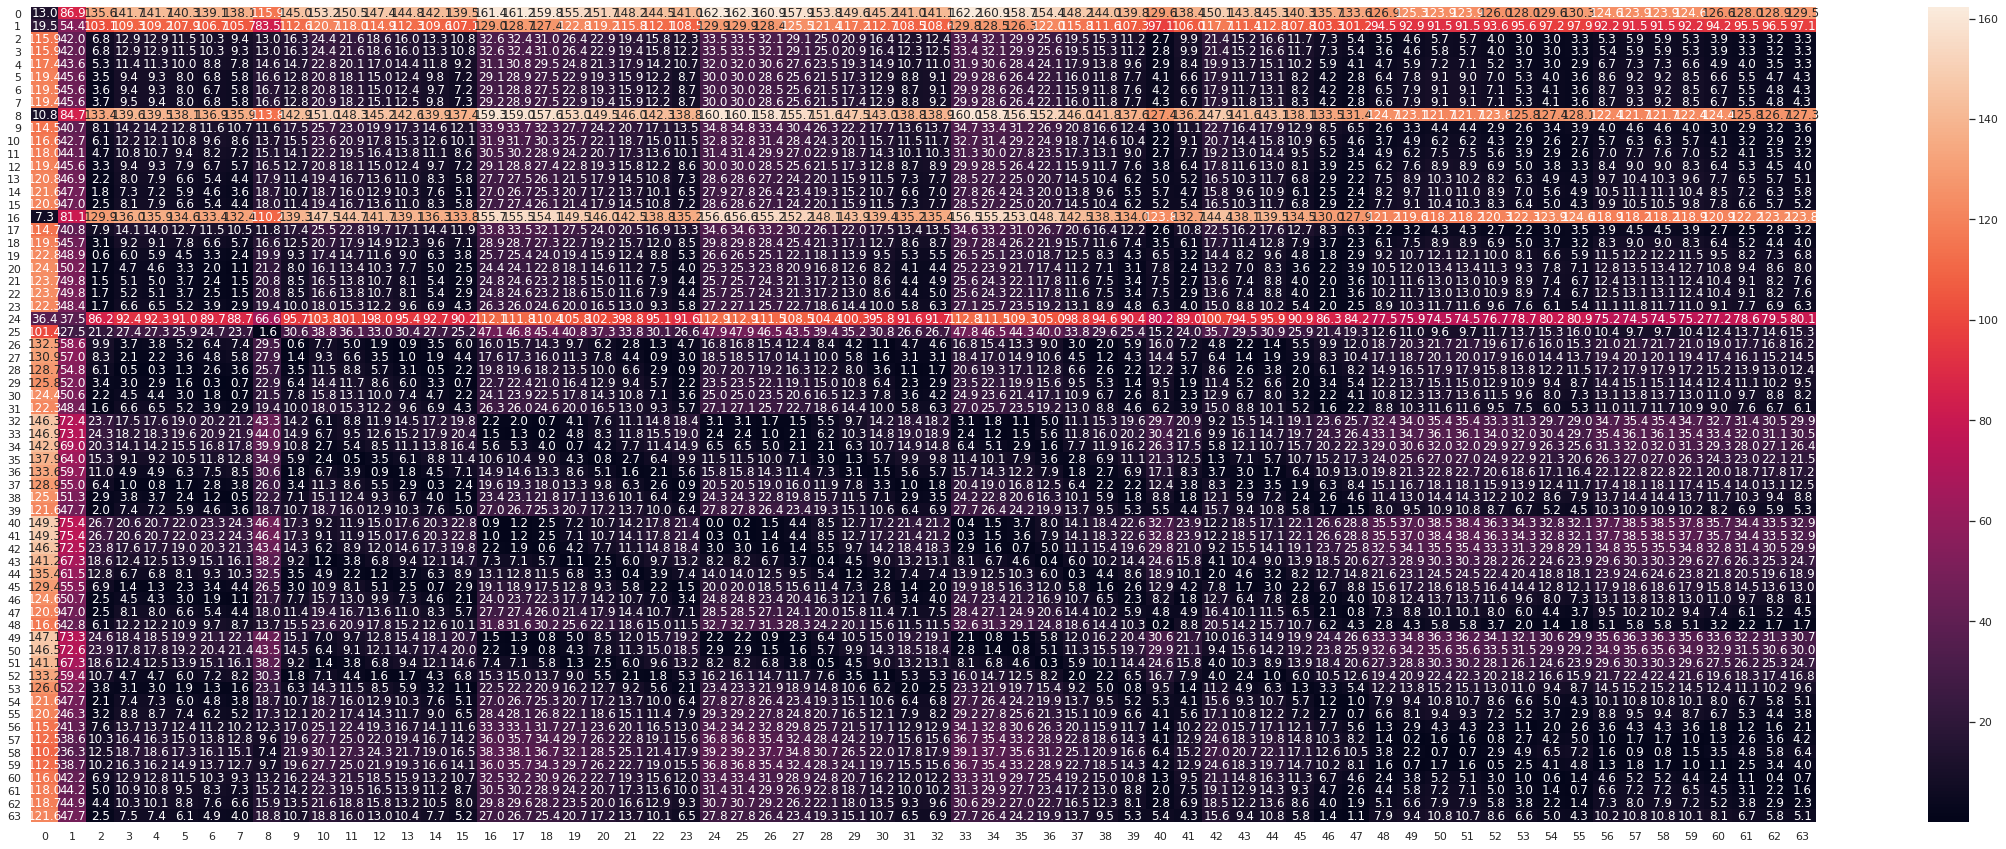

In [ ]:
plt.figure(figsize=(40,15))
sns.heatmap(distance_matrix_wdepth_catted, annot=True,fmt='0.1f')


In [7]:

coordinates_tensor = torch.stack(coordinates).unsqueeze(0).float()
coordinates_tensor /= sqrt(image_h ** 2 + image_w ** 2)
coordinates_tensor[:, 0] *= proj_image_h
coordinates_tensor[:, 1] *= proj_image_w





proj_coors_one = cutout_and_resize(coordinates_tensor, cutout_coordinates_one, output_size = proj_image_shape, mode = coord_cutout_interpolate_mode) 
proj_coors_two = cutout_and_resize(coordinates_tensor, cutout_coordinates_two, output_size = proj_image_shape, mode = coord_cutout_interpolate_mode) 

proj_coors_one, proj_coors_two = map(lambda t: rearrange(t, 'b c h w -> (b h w) c'), (proj_coors_one, proj_coors_two))
proj_depth_one_cutout, proj_depth_two_cutout = map(lambda t: rearrange(t, 'b c h w -> (b h w ) c'), (depth_one_cutout, depth_two_cutout))
pdist = nn.PairwiseDistance(p = 2)

num_pixels = proj_coors_one.shape[0]


proj_coors_one_expanded = proj_coors_one[:, None].expand(num_pixels, num_pixels, -1).reshape(num_pixels * num_pixels, 2)
proj_coors_two_expanded = proj_coors_two[None, :].expand(num_pixels, num_pixels, -1).reshape(num_pixels * num_pixels, 2)

depth_one_cutout = cutout_and_resize(depth, cutout_coordinates_one, output_size = proj_image_shape, mode = cutout_interpolate_mode) 
depth_two_cutout = cutout_and_resize(depth, cutout_coordinates_two, output_size = proj_image_shape, mode = cutout_interpolate_mode)
bs = depth_one_cutout.shape[0] 
proj_depth_one_cutout, proj_depth_two_cutout = map(lambda t: rearrange(t, 'b c h w ->b (h w) c'), (depth_one_cutout, depth_two_cutout))

proj_depth_one_expanded = proj_depth_one_cutout[:, :, None].expand(-1, num_pixels, num_pixels,-1).reshape(bs, num_pixels * num_pixels,1)
proj_depth_two_expanded = proj_depth_two_cutout[:, None, :].expand(-1, num_pixels, num_pixels,-1).reshape(bs, num_pixels * num_pixels,1)
print(f'proj_depth_two_expanded {proj_depth_two_expanded.shape}')
print(f'proj_depth_one_expanded {proj_depth_one_expanded.shape}')
intensity_matrix = ((proj_depth_one_expanded/255- proj_depth_two_expanded/255)**2).reshape(-1,num_pixels, num_pixels) #torch.cdist(proj_depth_one_expanded/255, proj_depth_two_expanded/255 , p=2)#.reshape(bs, num_pixels, num_pixels)
print(f'intensity_matrix {intensity_matrix.shape}')



distance_matrix = pdist(proj_coors_one_expanded, proj_coors_two_expanded) 
distance_matrix = distance_matrix.reshape(num_pixels, num_pixels)


intensity_matrix = pdist(proj_depth_one_expanded/255, proj_depth_two_expanded/255).reshape(num_pixels, num_pixels)


positive_mask_one_two = distance_matrix < distance_thres
positive_mask_two_one = positive_mask_one_two.t()



proj_depth_two_expanded torch.Size([1, 4096, 1])
proj_depth_one_expanded torch.Size([1, 4096, 1])
intensity_matrix torch.Size([1, 64, 64])


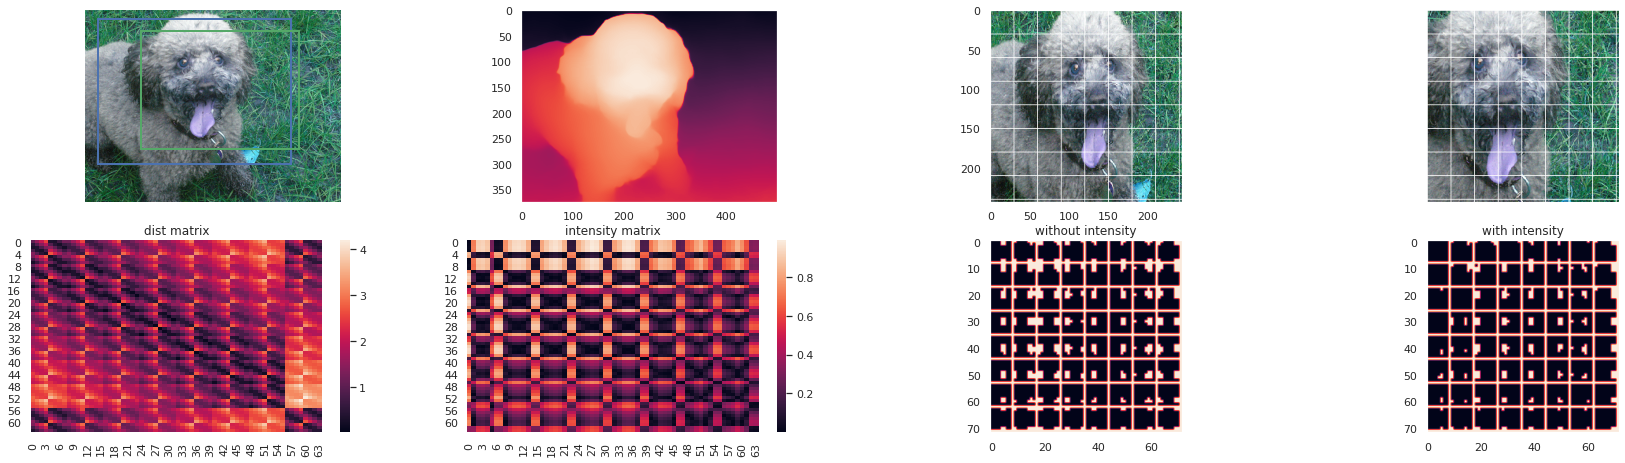

In [8]:

distance_matrix_wdepth_added = pdist(proj_coors_one_expanded, proj_coors_two_expanded)
distance_matrix_wdepth_added = distance_matrix_wdepth_added.reshape(num_pixels, num_pixels)

positive_mask_one_two_wdepth_added = distance_matrix_wdepth_added < distance_thres
positive_mask_one_two_wdepth_added = positive_mask_one_two_wdepth_added * (intensity_matrix < 0.2)
positive_mask_two_one_wdepth_added = positive_mask_one_two_wdepth_added.t()

plt.figure(figsize=(30,12))

plt.subplot(3,4,1)
plt.imshow(img.permute(0,2,3,1).squeeze())
plt.gca().add_patch(Rectangle(*get_xy_width_heights(cutout_coordinates_one),linewidth=2,edgecolor='b',facecolor='none'))
plt.gca().add_patch(Rectangle(*get_xy_width_heights(cutout_coordinates_two),linewidth=2,edgecolor='g',facecolor='none'))
plt.axis('off')

plt.subplot(3,4,2)
plt.imshow(depth.permute(0,2,3,1).squeeze())
plt.subplot(3,4,3)
dx, dy = 244//8,244//8
pimg_one = image_one_cutout.permute(0,2,3,1).squeeze().numpy()
# Custom (rgb) grid color
grid_color = [255,255,255]

# Modify the image to include the grid
pimg_one[:,::dy,:] = grid_color
pimg_one[::dx,:,:] = grid_color

plt.imshow(pimg_one)

plt.subplot(3,4,4)
pimg_two = image_two_cutout.permute(0,2,3,1).squeeze().numpy()
# Custom (rgb) grid color
grid_color = [255,255,255]

# Modify the image to include the grid
pimg_two[:,::dy,:] = grid_color
pimg_two[::dx,:,:] = grid_color

plt.imshow(pimg_two)




plt.axis('off')
plt.subplot(3,4,5)
plt.title('dist matrix')
sns.heatmap(distance_matrix_wdepth_added)
plt.subplot(3,4,6)
plt.title('intensity matrix')
sns.heatmap(intensity_matrix)
plt.subplot(3,4,7)
plt.title('without intensity')
imgg = torch.ones((72,72))

for i in range(8):
    for j in range(8):
        lien = positive_mask_one_two[8*i+j,:]
        imgg[9*i:9*(i+1)-1,9*j:9*(j+1)-1] = lien.view(8,8)
        plt.imshow(imgg)
plt.subplot(3,4,8)
plt.title('with intensity')
imgg = torch.ones((72,72))

for i in range(8):
    for j in range(8):
        lien = positive_mask_one_two_wdepth_added[8*i+j,:]
        imgg[9*i:9*(i+1)-1,9*j:9*(j+1)-1] = lien.view(8,8)
        plt.imshow(imgg)

